## Overview

__Business Problem__

As a business, it is difficult to assess the appropriate value for homes in certain neighborhoods/markets. There is a need for more precision and confidence in valuation to support decision-making. Developing a data-driven / model-based approach to valuation can help to remove human bias.

As a building developer, it is difficult to weigh the importance of attributes to potential home buyers. A model-based approach can help assess what factors drive the oveall value of a home.

__Inference Problem__

X: 79 explanatory variables describing aspects of residential homes in Ames, Iowa  
y: Home price

Develop a model to predict home price based on a collection of attributes about the home and surrounding neighborhood.

__Methodology__

- Exploratory data analysis
    - Use pandas profiling minimal for overview
    - Develop calculated metrics using numerical variables
    - Apply one-hot encoding to relevant ordinal variables
- Model setup
    - Baseline set of regression models
        - Linear Regression
        - Random Forest
        - Gradient Boosting
- Model evaluation and iteration
    - Evaluate performance metrics: $R^2$, MSE, MAE, RMSE, [placeholder]
    - Assess feature importance, apply dimensionality reduction
    - Determine which models to exclude, features to exclude/include/adjust
    - Repeat model setup

__Office Hours Walkthrough Notes__

- Error analysis
    - Residuals
        - How are we making errors - in the same variable, same direction?
    - We need to solve sub-problems
        - Example: Rather than the spectrum of HousePrice, maybe the proper distinction is Cheap vs. Expensive houses

## 0.0 Project Setup

### 0.1 Import libraries and data

In [1]:
# Basic
from IPython.display import display, Math
import warnings
warnings.filterwarnings('ignore')

# Statistics
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Modelling
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, SGDRegressor, Ridge, Lasso, BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Colab
train_url = "https://raw.githubusercontent.com/davidmiller2013/207-project-home-price/main/data/train.csv"
test_url = "https://raw.githubusercontent.com/davidmiller2013/207-project-home-price/main/data/test.csv"
house_train = pd.read_csv(train_url)
house_test = pd.read_csv(test_url)

# Local
# house_train = pd.read_csv('../data/train.csv')
# house_test = pd.read_csv('../data/test.csv')

## 1.0 Exploratory Data Analysis

### 1.1 Initial EDA

In [3]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(f"The shape of the dataset is {house_train.shape}.")
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
print("Below are the features and the number of non-null observations of the features")
house_train.info()
print("\n")

print("\033[1m" + "Numeric Column Information" + "\033[0m")
print(house_train.describe())
print("\n")

print("\033[1m" + "Categorical Column Unique Values" + "\033[0m")
for col in house_train:
    if len(house_train[col].unique()) > 10:
        pass
    else:
        print('{}: {}'.format(col, house_train[col].unique()))

Dataframe Shape
The shape of the dataset is (1460, 81).


Column Information
Below are the features and the number of non-null observations of the features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null

In [4]:
# prof = ProfileReport(house_train, minimal=True)
# prof.to_file(output_file='output.html')

The `output.html` file displays information about each variable, including the number of distinct values, missing values, mean, minimum, maximum, and the distribution. From going through the list and reading the description of the features in `data_description.txt`, we chose 3 features to use for our model to predict home price. They are `LotArea`, `BedroomAbvGr`, and `FullBath`. The `LotArea` is the lot size in square feet, `BedroomAbvGr` is the number of bedrooms above grade, and `FullBath` is the number of full bathrooms above grade. We believe these features will be quite predictive of the house price.

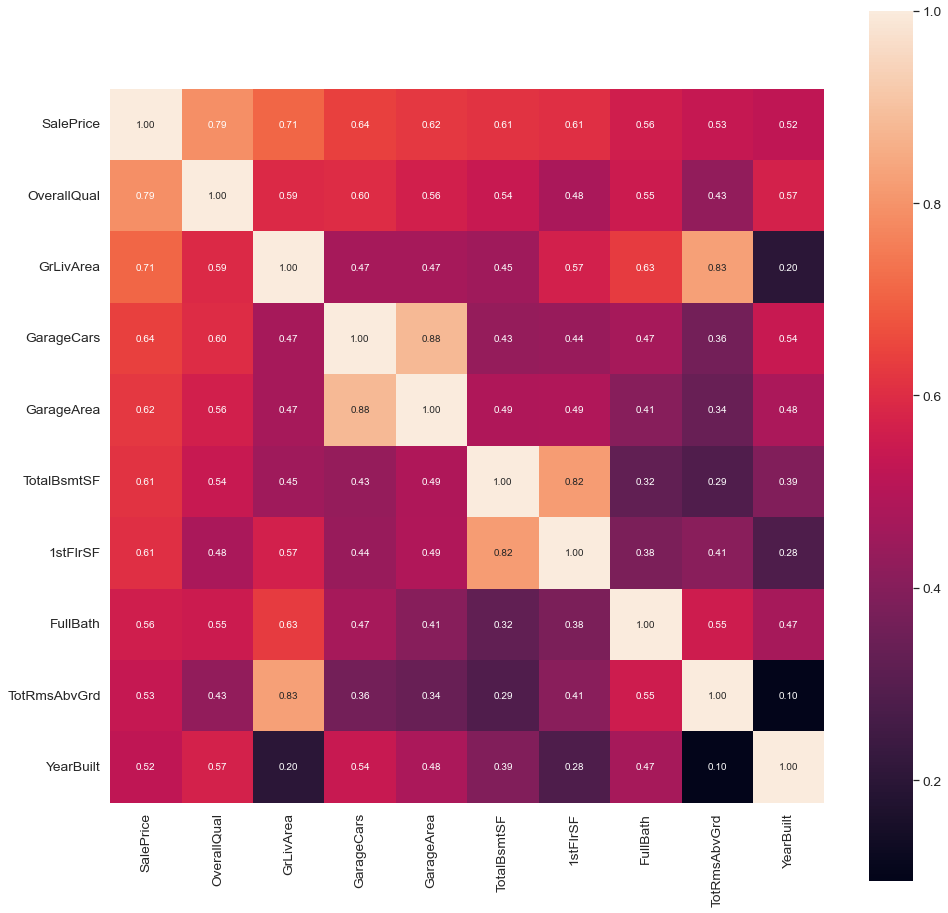

In [5]:
corrmat = house_train.corr()
k = 10

plt.figure(figsize=(16,16))
columns = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(house_train[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix,
                       cbar=True,
                       annot=True,
                       square=True,
                       fmt='.2f',
                       annot_kws={'size': 10},
                       yticklabels=columns.values,
                       xticklabels=columns.values
                      )
plt.show()

## 2.0 Feature Engineering

### 2.1 Handle Missing Data

In [6]:
def missing_ratio(df):
    '''Calculate % of observations with a NaN value for each column of a df'''
    data_na = (df.isnull().sum() / len(df)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index)\
                     .sort_values(ascending=False)[:30]

    missing_data = pd.DataFrame({'Missing Ratio': data_na})
    return missing_data

missing_ratio(house_train)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [7]:
def handle_missing_data(df,
                        drop_features=None,
                        none_features=None,
                        med_features=None,
                        mode_features=None,
                        convert_features=None
                       ):
    '''
    Perform basic feature engineering as applicable to each feature / set of features.
    Includes imputation of NaN, mean normalization, and feature dropping.

    df:                the dataframe to be transformed
    drop_features:     columns that should be dorpped from the dataframe
    none_features:     columns where NaN should be replaced with None or 0
    med_features:      numeric columns where NaN should be replaced with the median value
    mode_features:     numeric columns where NaN should be replaced with the mode value
    convert_features:  numeric columns that should be converted to ordinal features
    '''
    
    df = df.drop(drop_features, axis=1)

    for feature in none_features:
        if df[feature].dtype == 'O':
            df[feature] = df[feature].fillna("None")
        else:
            df[feature] = df[feature].fillna(0)
    
    for feature in med_features:
        df[feature] = df[feature].fillna(df[feature].median()[0])
    
    for feature in mode_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    
    for feature in convert_features:
        df[feature] = df[feature].astype(str)
    
    return df




In [8]:
# Features to drop from df
drop_features = ['Id', 'Utilities'] # all same value except for 2 NA

# Features to replace NaN with None or 0 - logical assumption that NaN means the house does not have X feature
none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual',
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',
                 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'MSSubClass'
                ]

# Features to fill NaN with the median value of the column
med_features = []


# Features to fill NaN with the mode value of the column
mode_features = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                 'SaleType'
                ]
    
# Numeric features that are actually ordinal and should be converted
convert_features = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']

house_train = handle_missing_data(house_train,
                                  drop_features,
                                  none_features,
                                  med_features,
                                  mode_features,
                                  convert_features
                                 )


### 2.2 Custom transformation

In [9]:
def custom_feature_engineering(df):
    '''Apply custom operations to dataframe. Contained in a function for re-use with test data'''

    # Fill NaN values for LotFrontage with median in each neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # For Functional column, data_description.txt indicates that NaN = Typ
    df['Functional'] = df['Functional'].fillna('Typ')

    # Calculate total sqft of house as a new feature
    df['TotalSF'] = df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)

    return df

house_train = custom_feature_engineering(house_train)

In [10]:
# Check that there are no remaining missing values
missing_ratio(house_train)

,Missing Ratio


### 2.X Normalizing variables

In [11]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = house_train['LotArea'].skew()
pd_kurt    = house_train['LotArea'].kurt()
sci_skew   = skew(house_train['LotArea'], bias=False)
sci_kurt   = kurtosis(house_train['LotArea'], bias=False)
sci_skew_b = skew(house_train['LotArea'], bias=True)
sci_kurt_b = kurtosis(house_train['LotArea'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

,skew,kurtosis
pandas,12.207688,203.243271
scipy-unbiased,12.207688,203.243271
scipy-biased,12.195142,202.543793


In [12]:
# Calculate skew and kurtosis of all numerical features
num_features = house_train.dtypes[house_train.dtypes != "object"].index
skew_features = house_train[num_features].apply(lambda x: pd.Series({'skew': x.skew(),
                                                                     'kurtosis': x.kurtosis()
                                                                    }))
skew_df = pd.DataFrame({'skew': skew_features.loc['skew'],
                        'kurtosis': skew_features.loc['kurtosis']
                       }).sort_values(by='skew', ascending=False)
skew_df

,skew,kurtosis
MiscVal,24.476794,701.003342
PoolArea,14.828374,223.268499
LotArea,12.207688,203.243271
3SsnPorch,10.304342,123.662379
LowQualFinSF,9.011341,83.234817
KitchenAbvGr,4.488397,21.532404
BsmtFinSF2,4.255261,20.113338
ScreenPorch,4.122214,18.439068
BsmtHalfBath,4.103403,16.396642
EnclosedPorch,3.089872,10.430766


In [13]:
# Apply boxcox transformation to skewed features
from scipy.special import boxcox1p
from sklearn.preprocessing import PowerTransformer


# Explore 2 methods using highly skewed feature
temp = pd.DataFrame(house_train['LotArea'])

# Take the log10 of votes
temp['LotArea_Norm'] = boxcox1p(temp['LotArea'], 0)

# Apply power transformation
pt = PowerTransformer()
temp['LotArea_Power'] = pt.fit_transform(pd.DataFrame(temp['LotArea']))


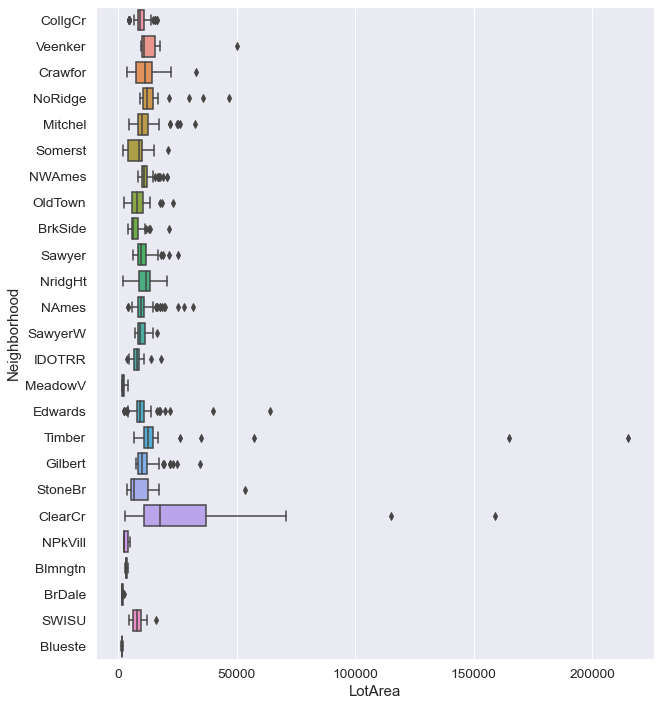

In [14]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='LotArea', y='Neighborhood', orient='h', data=house_train)
plt.show()

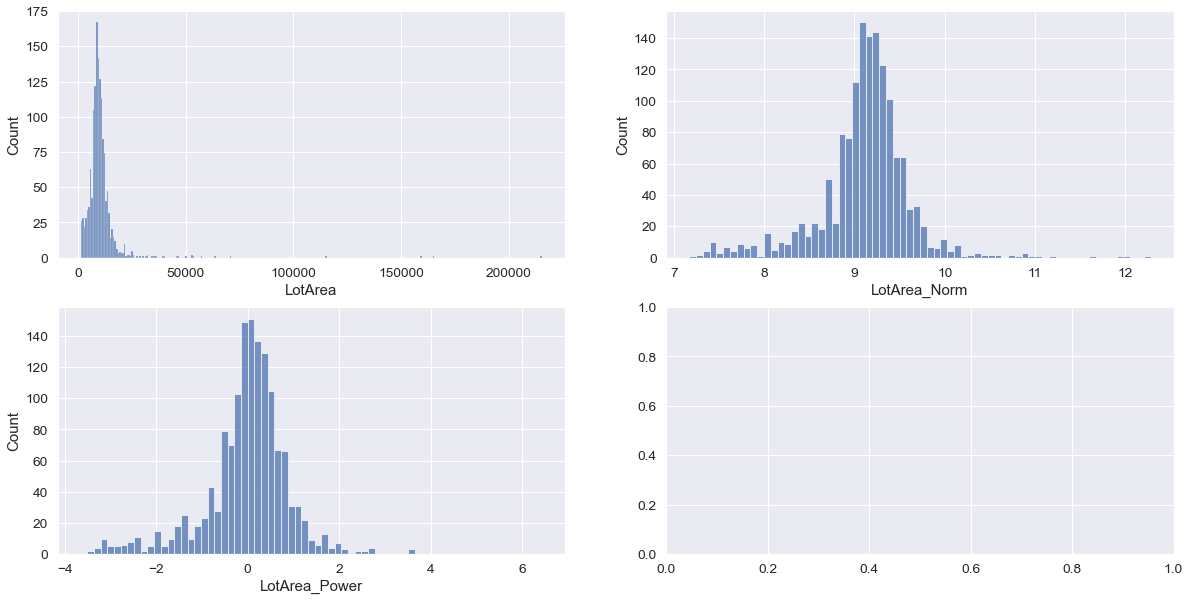

In [15]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='LotArea',
             data=temp,
             ax=ax[0][0]
            )

sns.histplot(x='LotArea_Norm',
             data=temp,
             ax=ax[0][1]
            )

sns.histplot(x='LotArea_Power',
             data=temp,
             ax=ax[1][0]
            )

plt.show()

In [16]:
# Use a power transformer to normalize all featuers with skew > 1

skew_df = skew_df[abs(skew_df['skew']) > 1]
skewed_features = list(skew_df.index)
pt = PowerTransformer()
house_train[skewed_features] = pt.fit_transform(house_train[skewed_features])

### 2.X Encoding variables

In [17]:
# Simple pandas function to replicate a OneHotEncoder
house_train = pd.get_dummies(house_train)

### 2.X Apply across test data

In [18]:
# INCOMPLETE - to be updated once feature engineering is finalized on training data

# Apply same functions to test data
house_test = handle_missing_data(house_test,
                                 drop_features,
                                 none_features,
                                 med_features,
                                 mode_features,
                                 convert_features
                                )


house_test = custom_feature_engineering(house_test)



## 3.0 Model building

In [19]:
def plot_residual(y_pred, y_dev):
    residuals = y_dev - y_pred
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Value')
    plt.ylabel('Residals')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

### 3.1 Model v1 - Simple linear regression

For our baseline, we are building a linear regression model with `LotArea`, `BedroomAbvGr`, and `FullBath` as features.

In [20]:
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = house_train[initial_features], house_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [21]:
reg = LinearRegression().fit(X_train, y_train)
r2 = reg.score(X_train, y_train)

display(Math(r'R^2 \text{{ for our initial linear regression model is }} {:.2f}'.format(r2)))

<IPython.core.display.Math object>

In [22]:
x1, x2, x3 = reg.coef_
intercept = reg.intercept_
print("The initial model function is: y = {:.2f}x1 + {:.2f}x2 + {:.2f}x3 + {:.2f}".format(x1, x2, x3, intercept))

The initial model function is: y = 0.32x1 + -0.06x2 + 0.97x3 + -1.35


In [23]:
y_pred = reg.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
mse = mean_squared_error(y_dev, y_pred, squared=True)
rmse = mean_squared_error(y_dev, y_pred, squared=False)
        
print("The mean absolute error is {:.2f}.".format(mae))
print("The mean squared error is {:.2f}.".format(mse))
print("The root mean squared error is {:.2f}.".format(rmse))

The mean absolute error is 0.53.
The mean squared error is 0.52.
The root mean squared error is 0.72.


#### Calculate residuals

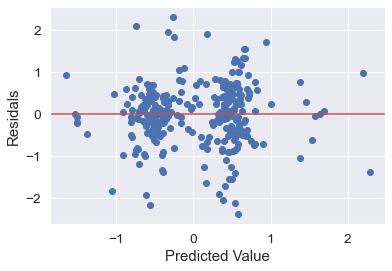

In [24]:
plot_residual(y_pred, y_dev)

### 3.2 Model v2 - Linear regression with complete set of features

In [25]:
X, y = house_train.drop('SalePrice', axis=1), house_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
r2 = reg.score(X_train, y_train)
display(Math(r'R^2 \text{{ for our initial linear regression model is }} {:.2f}'.format(r2)))

y_pred = reg.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
mse = mean_squared_error(y_dev, y_pred, squared=True)
rmse = mean_squared_error(y_dev, y_pred, squared=False)
        
print("The mean absolute error is {:.2f}.".format(mae))
print("The mean squared error is {:.2f}.".format(mse))
print("The root mean squared error is {:.2f}.".format(rmse))

<IPython.core.display.Math object>

The mean absolute error is 0.24.
The mean squared error is 0.13.
The root mean squared error is 0.37.


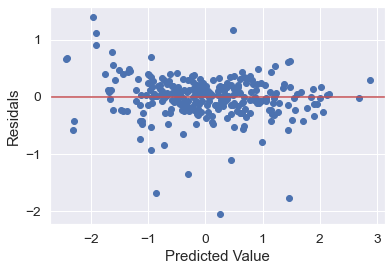

In [26]:
plot_residual(y_pred, y_dev)

### 3.X Cross validation

In [27]:
# Validation function
n_folds = 5

def model_cross_val(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf)).mean()
    return rmse

### 3.X Model selection

In [28]:
# Lasso ridge
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic net
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# Kernel ridge
krr = KernelRidge(alpha=0.6,
                  kernel='polynomial',
                  degree=2,
                  coef0=2.5
                 )

# Gradient boosting
gboost = GradientBoostingRegressor(n_estimators=3000,
                                   learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=10, 
                                   loss='huber',
                                   random_state=5
                                  )

# XGBoost
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603,
                           gamma=0.0468, 
                           learning_rate=0.05,
                           max_depth=3, 
                           min_child_weight=1.7817,
                           n_estimators=2200,
                           reg_alpha=0.4640,
                           reg_lambda=0.8571,
                           subsample=0.5213,
                           silent=1,
                           random_state=7,
                           nthread=-1
                          )

# LightGB
lgboost = lgb.LGBMRegressor(objective='regression',
                            num_leaves=5,
                            learning_rate=0.05, 
                            n_estimators=720,
                            max_bin=55,
                            bagging_fraction=0.8,
                            bagging_freq=5,
                            feature_fraction=0.2319,
                            feature_fraction_seed=9,
                            bagging_seed=9,
                            min_data_in_leaf=6,
                            min_sum_hessian_in_leaf=11
                           )

# Random forest
rforest = RandomForestRegressor(max_depth=2, random_state=0)

names = ['Lasso', 'Elastic Net', 'Kernel Ridge', 'Gradient Boost', 'XGBoost', 'LightGB', 'Random Forest']
models = [lasso, enet, krr, gboost, xgboost, lgboost, rforest]

models = dict(zip(names, models))

In [29]:
def model_cross_val(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf)).mean()
    return rmse

In [30]:
%%time
# Note this cell takes a very long time to execute unless using a GPU 
print("RMSE for each model in our set")
print("------------------------------")

for name, model in models.items():
    rmse = model_cross_val(model, X_train, y_train)
    print("{}: {:4f}".format(name, rmse))

print("\n")

RMSE for each model in our set
------------------------------
Lasso: 0.345967
Elastic Net: 0.347046
Kernel Ridge: 0.650307
Gradient Boost: 0.308531
[14:01:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:01:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:02:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some paramete

Residual plot for each model in our set
------------------------------


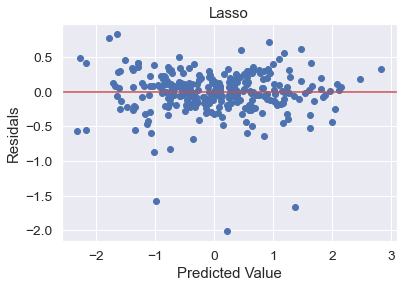

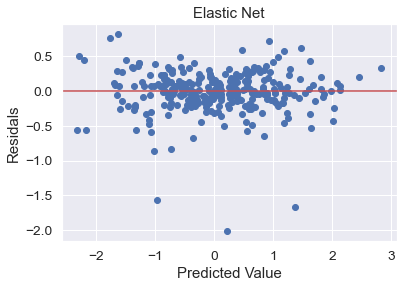

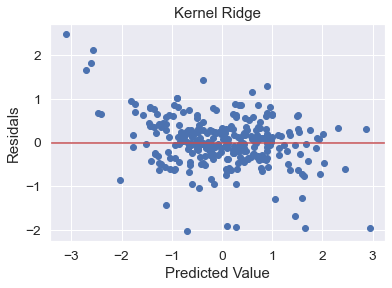

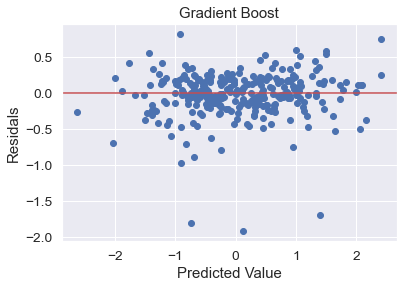

[14:02:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




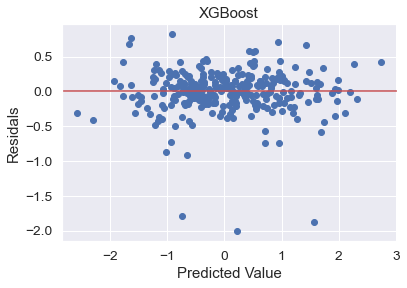

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


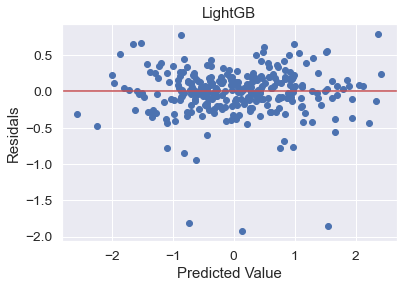

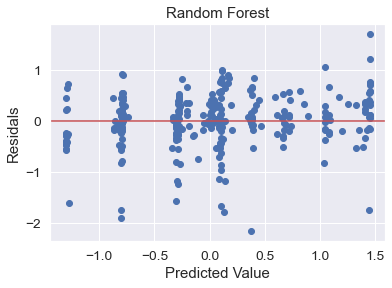

CPU times: user 56.1 s, sys: 12.2 s, total: 1min 8s
Wall time: 18.2 s


In [31]:
%%time
print("Residual plot for each model in our set")
print("------------------------------")

for name, model in models.items():
    plt.title(f'{name}')
    fitted_model = model.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_dev)
    plot_residual(y_pred, y_dev)